# 7.1 ポアソン回帰(Poisson regression)

In [1]:
# パッケージの読み込み
using Distributions, PyPlot, ForwardDiff, LinearAlgebra

In [2]:
# n次元単位行列
eye(n) = Diagonal{Float64}(I, n)

# パラメータ抽出用の関数
unzip(a) = map(x -> getfield.(a, x), fieldnames(eltype(a)))

unzip (generic function with 1 method)

In [3]:
function set_options(ax, xlabel, ylabel, title;
                     grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
    return
end

set_options (generic function with 1 method)

In [4]:
# ハミルトニアンモンテカルロ法
function HMC(log_p_tilde, μ₀; maxiter::Int=100_000, L::Int=100, ϵ::Float64=1e-1)
    # leapfrogによる値の更新
    function leapflog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5 * ϵ * grad(μ)
        for l in 1:L-1
            μ += ϵ * p
            p += ϵ * grad(μ)
        end
        μ += ϵ * p
        p += 0.5 * ϵ * grad(μ)
        p, μ
    end
    
    # 非正規化対数事後分布の勾配関数を計算
    grad(μ) = ForwardDiff.gradient(log_p_tilde, μ)
    
    # サンプルを格納する配列
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    
    # 初期サンプル
    μ_samples[:, 1] = μ₀
    
    # 受容されたサンプルの数
    num_accepted = 1
    
    for i in 2:maxiter
        # 運動量 p の生成
        p_in = randn(size(μ₀))
        
        # リープフロッグ法
        p_out, μ_out = leapflog(grad, p_in, μ_samples[:, i-1], L, ϵ)
                
        # 比率 r (の対数)を計算
        μ_in = μ_samples[:, i-1]
        log_r = (log_p_tilde(μ_out) +
                 logpdf(MvNormal(zeros(D), eye(D)), vec(p_out))) -
                (log_p_tilde(μ_in) +
                 logpdf(MvNormal(zeros(D), eye(D)), vec(p_in)))
        
        # 確率 r でサンプルを受容する
        is_accepted = min(1, exp(log_r)) > rand()
        new_samples = is_accepted ? μ_out : μ_in
        
        # 新しいサンプルを格納
        μ_samples[:, i] = new_samples
        
        # 受容された場合、合計をプラスする
        num_accepted += is_accepted
    end
    
    μ_samples, num_accepted
end

HMC (generic function with 1 method)

In [5]:
# ラッパー関数の定義
function inference_wrapper_HMC(log_joint, paras, w_init; 
                               maxiter::Int=100000, L::Int=100, ϵ::Float64=1e-1)
    ulp(w) = log_joint(w, paras...)
    HMC(ulp, w_init, maxiter=maxiter, L=L, ϵ=ϵ)
end

inference_wrapper_HMC (generic function with 1 method)

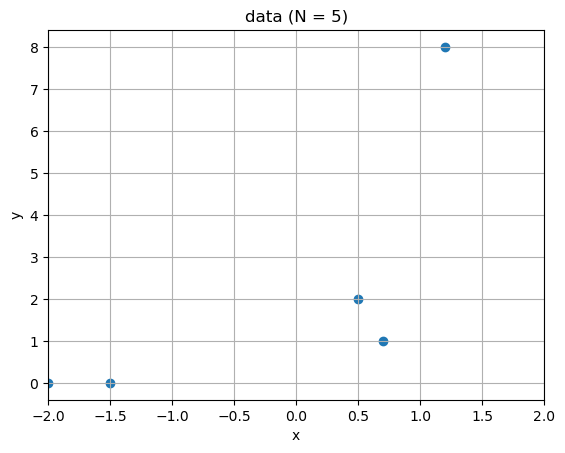

In [6]:
# 入力データセット
X_obs = [-2, -1.5, 0.5, 0.7, 1.2]

# 出力データセット
Y_obs = [0, 0, 2, 1, 8]

# 散布図で可視化
fig, ax = subplots()
ax.scatter(X_obs, Y_obs)
ax.set_xlim([-2, 2])
set_options(ax, "x", "y", "data (N = $(length(X_obs)))")

In [7]:
# 事前分布の設定
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 1.0
σ₂ = 1.0

1.0

In [8]:
# 対数同時分布
log_joint(w, X, Y) = 
    logpdf(Normal(μ₁, σ₁), w[1]) +
    logpdf(Normal(μ₂, σ₂), w[2]) +
    sum(logpdf.(Poisson.(exp.(w[1]*X .+ w[2])), Y))

# 非正規化対数事後分布
paras = (X_obs, Y_obs)
ulp(w) = log_joint(w, paras...)

ulp (generic function with 1 method)

In [9]:
# 初期値
w_init = randn(2)

# サンプリング
maxiter = 300
param_posterior_HMC, num_accepted_HMC =
    inference_wrapper_HMC(log_joint, paras, w_init, maxiter=maxiter)

([-0.6555404415425528 3.930534009906727 … 1.5215055847373313 1.756785685396468; 0.6675946550100326 -1.90438728807628 … -0.299773477929974 -0.58288668081944], 297)

acceptance rate (HMC) = 0.99


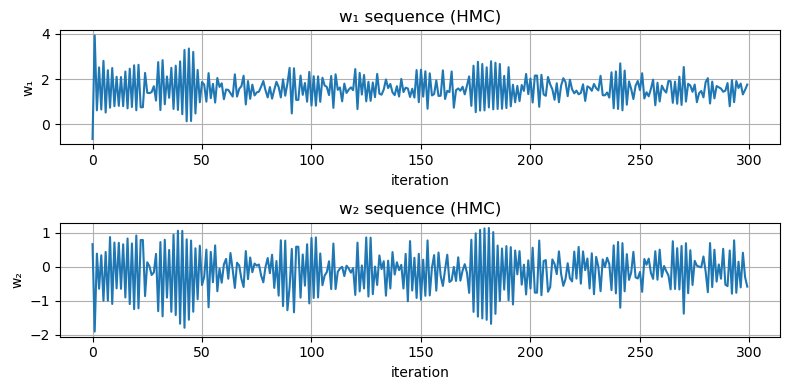

In [10]:
# サンプリングの過程を可視化(HMC)
fig, axes = subplots(2, 1, figsize=(8, 4))
axes[1].plot(param_posterior_HMC[1, :])
set_options(axes[1], "iteration" , "w₁", "w₁ sequence (HMC)")
axes[2].plot(param_posterior_HMC[2, :])
set_options(axes[2], "iteration" , "w₂", "w₂ sequence (HMC)")
tight_layout()
println("acceptance rate (HMC) = $(num_accepted_HMC/maxiter)")

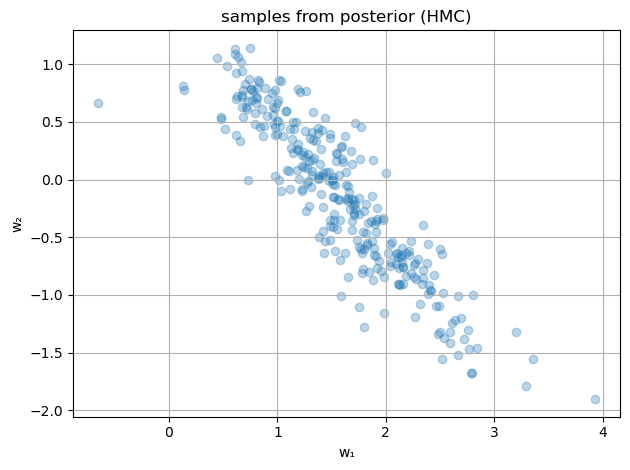

In [11]:
# HMCで得られた事後分布からのサンプル
fig, ax = subplots()
ax.scatter(param_posterior_HMC[1,:], param_posterior_HMC[2,:], alpha=0.3)
set_options(ax, "w₁", "w₂", "samples from posterior (HMC)")
tight_layout()

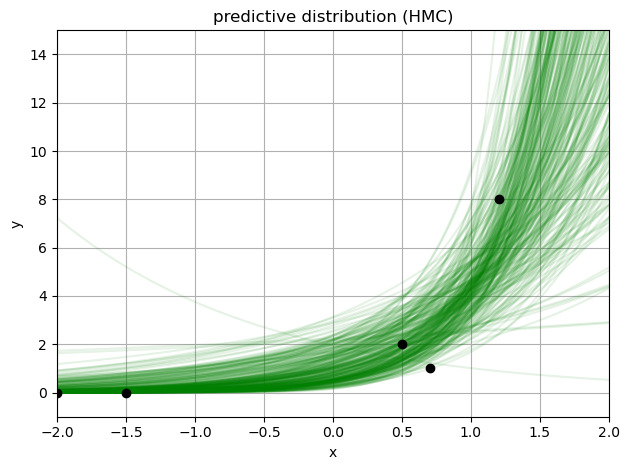

In [12]:
# 関数を可視化する範囲
xs = range(-2, 2, length=100)

fig, ax = subplots()

# HMC によるサンプル
for i in 1:size(param_posterior_HMC, 2)
    w₁, w₂ = param_posterior_HMC[:, i]
    # 指数関数を可視化
    f(x) = exp.(w₁ * x + w₂)
    ax.plot(xs, f.(xs), "g", alpha=0.1)
end
ax.plot(X_obs, Y_obs, "ko")
ax.set_xlim(extrema(xs))
ax.set_ylim([-1, 15])
set_options(ax, "x", "y", "predictive distribution (HMC)")

tight_layout()